## Import 

In [89]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers


In [90]:
# Load the dataset
df = pd.read_csv('fer2013/fer2013.csv')

## Preprocessing

In [91]:
# Convert pixels from strings to lists of integers
df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])

# Reshape to 48x48 and normalize
images = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1)
images = (images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000  # Adjust based on the size of your dataset
BATCH_SIZE = 128  # Modify according to your system's capability

# Batch and shuffle the data with TensorFlow's Dataset API
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## Training

In [92]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(12*12*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((12, 12, 256)))
    assert model.output_shape == (None, 12, 12, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 48, 48, 1)

    return model

generator = make_generator_model()


In [93]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[48, 48, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Additional layers may be needed to reduce dimensions appropriately

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()


In [94]:
# This method returns a helper function to compute cross-entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
#WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)


In [95]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed to visualize progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [96]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [97]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


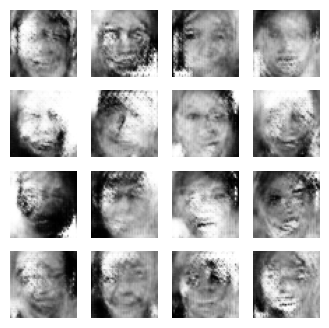

In [98]:
import time
from IPython import display

def train(dataset, epochs):
    start = time.time()
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every specified number of epochs (e.g., every 5 epochs)
        if (epoch + 1) % 5 == 0:
            save_path = manager.save()
            print("Saved checkpoint for epoch {}: {}".format(epoch+1, save_path))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Then, execute the training function with your dataset and specified number of epochs
train(train_dataset, EPOCHS)

In [99]:
generator.save('generator')
discriminator.save('discriminator')

INFO:tensorflow:Assets written to: generator/assets


INFO:tensorflow:Assets written to: generator/assets


INFO:tensorflow:Assets written to: discriminator/assets


INFO:tensorflow:Assets written to: discriminator/assets


In [108]:
import imageio
import os

# Directory containing PNG images
image_folder = './img' 
images = []

# Assuming your images are named sequentially (e.g., image1.png, image2.png, ..., image50.png)
for i in range(1, 10):
    image_path = os.path.join(image_folder, f'image_at_epoch_000{i}.png')
    images.append(imageio.imread(image_path))

for i in range(10, 51):
    image_path = os.path.join(image_folder, f'image_at_epoch_00{i}.png')
    images.append(imageio.imread(image_path))

# Save the images as a GIF
output_path = os.path.join(image_folder, 'epoch_1_50.gif')
imageio.mimsave(output_path, images, duration=0.5)


/var/folders/h2/83y5fcnn0lv0pbrx9m9lkx6m0000gn/T/ipykernel_11629/2164755203.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))
/var/folders/h2/83y5fcnn0lv0pbrx9m9lkx6m0000gn/T/ipykernel_11629/2164755203.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))
